# Task Overview

Your task will be to implement a variant of *ProxyProp* (Proximal Backpropagation) – a modification of backpropagation in which the weights of the network are not updated according to gradient descent, but according to [proximal mapping operator](https://en.wikipedia.org/wiki/Proximal_operator). This proximal operator in many cases results in a descent that is quicker than in the case of traditional gradient descent. Interestingly enough, the proximal operator arose in the context of gradient descent in which the minimized function is not differentiable, and gradient descent cannot be applied directly as we cannot compute the Jacobi matrix. This method is called [proximal gradient method](https://en.wikipedia.org/wiki/Proximal_gradient_method). However, we are interested here in the efficiency of the approach rather than its robustness. The backpropagation method in the proximal approach (i.e. *ProxyProp* algorithm) is described in detail in [this paper](https://arxiv.org/pdf/1706.04638v3).

The original algorithm presented in the paper uses purely linear transformations between subsequent network layers. Part of your task is to use affine transformations there, i.e. ones with biases.

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (9pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 6pt implement the backpropagation
2. Train the models (find proper hyperparameters). Visualize the learning speed of your best model compared with the standard backpropagation (plot training loss for subsequent numbers of epochs using both algorithms). Your model should reach at least 94% accuracy. Use ClearML to log your scores. Make a comparison of memory usage for _ProxProp_ network and the network you implemented in lab 3.
  - 1pt for accuracy above 94%
  - 1pt for initialization of the standard backpropagation and ProxyProp with the same random values
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.

Part of the assignment consists of deriving proper formulas for a proposed slight modification of _ProxProp_. We do not grant points separately for this activity. You are rewarded for that only after proper implementation.


## Potential questions, clarifications
- Q: Can I modify code of _ProxyProp_ outside #Your code goes here # to include logging?
  - Yes, in ProxyProp.SGD
- Q: Can I modify the code of _Network_ to include logging?
  - Yes.

In [1]:
%pip install clearml
%pip install memory-profiler
%pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.9.0
    Uninstalling PyJWT-2.9.0:
      Successfully uninstalled PyJWT-2.9.0


In [2]:
import numpy as np
from clearml import Logger
from typing import List

In [3]:
%load_ext memory_profiler

# Dataset loading


In [4]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2024-11-17 19:59:08--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.232.248, 3.5.21.36, 54.231.163.152, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.232.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  14.8MB/s    in 0.7s    

2024-11-17 19:59:09 (14.8 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [5]:
def load_mnist(path: str = "mnist.npz"):
    with np.load(path) as f:
        x_train, _y_train = f["x_train"], f["y_train"]
        x_test, _y_test = f["x_test"], f["y_test"]

    x_train = x_train.reshape(-1, 28 * 28) / 255.0
    x_test = x_test.reshape(-1, 28 * 28) / 255.0

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [6]:
### Your code goes here ###
from clearml import Task

web_server = 'https://app.clear.ml'
api_server = 'https://api.clear.ml'
files_server = 'https://files.clear.ml'
access_key = ''
secret_key = ''

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

task = Task.create(project_name='DNN', task_name='BackPropTask')
task.mark_started()
myLogger = task.get_logger()
###########################

# A quick recap of the backpropagation model

## Forward pass

We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

To compute gradients, use the following formulas:

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial f^{(l)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial f^{(l)}} \cdot g^{(l-1)}
\nonumber
%\end{equation}
$$

$l = L, L-1, \ldots, 1$.

# Network definition (as in laboratory 3)


In [7]:
def sigmoid(z: np.ndarray) -> float:
    return 1.0 / (1.0 + np.exp(-z))


def logloss(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    return -(np.log(x) * y).sum() / y.shape[1]

In [8]:
class Network(object):
    def __init__(
        self,
        sizes: List[int],
        weights: np.ndarray = None,
        biases: np.ndarray = None,
        seed: int = None
    ) -> None:
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        if seed is not None:
          np.random.seed(seed)
        self.num_layers = len(sizes)
        self.sizes = sizes
        if biases is not None:
          self.biases = biases
        else:
          self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        if weights is not None:
          self.weights = weights
        else :
          self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def update_mini_batch(
        self,
        mini_batch: tuple[np.ndarray, np.ndarray],
        eta: float,
    ):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w, loss = self.backprop(mini_batch[0].T, mini_batch[1].T)

        self.weights = [
            w - (eta / len(mini_batch[0])) * nw for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - (eta / len(mini_batch[0])) * nb for b, nb in zip(self.biases, nabla_b)
        ]
        return loss

    def backprop(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ) -> tuple[np.ndarray, np.ndarray, float]:
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w, g in reversed(list(zip(self.weights, gs[1:]))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf, g.T) for dLdf, g in zip(reversed(dLdfs), gs[:-1])]
        dLdBs = [
            np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) for dLdf in reversed(dLdfs)
        ]
        return (dLdBs, dLdWs, loss)

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            wloss = loss / (x_train.shape[0] // mini_batch_size)
            if logger is not None:
                logger.report_scalar(
                    title="Loss", series="Standard Loss", iteration=j + 1, value=wloss
                )
            if test_data:
                acc = self.evaluate((x_test, y_test))
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))


# Simple check if all is fine
network = Network([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test)
)

Epoch: 0, Accuracy: 0.8114, Loss: 1.2212297407841022
Epoch: 1, Accuracy: 0.8686, Loss: 0.589391246603474


# The original ProxProp definition

Let us fix the notation for our network as in the following figure. We can see here a series of layers with $n_0,\ldots, n_{L-2}$ nodes. Each layer is composed of input nodes that depend linearly ($\phi$ operator) on the output nodes that depend non-linearly on the respective input nodes ($\sigma$ operator). The quality of the final output is measured by the final loss function ${\cal L}_y$ (typically $\frac{1}{2}\|\cdot\|^2$).




![image.png]( 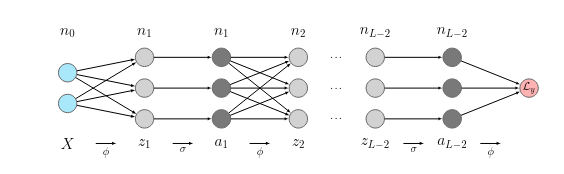)

_ProxProp_ procedure itself works similarly to a standard backpropagation procedure, as shown in the following figure.


![image.png]( 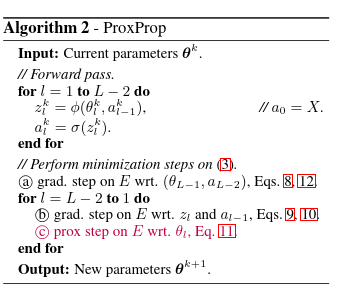)

For comparison, the standard backpropagation algorithm in this setting is as follows:


![image.png]( 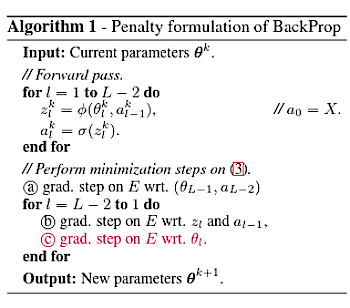)

Forward: The forward propagation phase is just as in the standard algorithm:

$z^k_l = \phi(\theta^k_l, a^k_{l−1}),$

$a^k_l = \sigma(z^k_l),$

where $\phi$ is supposed to be a linear transformation with weights $\theta^k_l$ over values $a^k_{l-1}$ and $\sigma$ is some non-linear step, e.g. the sigmoid function or the LeRU. You can use the sigmoid function for the purposes of this work.

Reverse: In the backpropagation, the step for the final layer ((a) on the figure) is exactly as in the gradient based version. In steps for the earlier layers, we recompute the z's and a's using the gradient method ((b) on the figure), but the weights are computed according to the proximal operator ((c) on the figure).

In step (a) the updated value is

$a'^{k}_{L−2} = a^k_{L−2} − \eta\nabla_{a_{L−2}} {\cal L}_y(\phi(\theta_{L−1}, a_{L−2})),$

where $\eta$ is the learning speed coefficient.

In case (b) the updated values are

$z'^{k}_l = z^k_l − \sigma'(z^k_l)(\sigma(z^k_l) − a'^k_l),$

$a'^{k}_{l−1} = a^k_{l−1} − \nabla( \frac{1}{2}\| \phi(θ^l, \cdot) − z'^k_l \|^2)(a^k_{l−1}),$

Note that the primed $a$-values are used to compute primed $z$-values and primed $z$-values are used to obtain the final value of $\theta^{k+1}$.

In case (c) the updated values are computed according to the proximal formula:

$$
\theta^{k+1}_l = \underset{\gamma}{\mathrm{argmin}} \left(\frac{1}{2} \|\phi(\gamma, a^k_{l−1}) − z'^k_l\|^2 + \frac{1}{2\tau_\theta}\|\gamma - \theta^k_l\|^2\right)
$$

The computation for the final layer is not done according to the proximity formula as it is difficult to obtain the closed formula for the necessary update, therefore it should be done according to the standard gradient descent.

The original formulas from the mentioned above paper do not use the biases. Part of the assignment is to rework this method so that the formulas include biases. You should develop a method in which biases are updated using the standard gradient descent method and the linear weight are updated using the _PropProx_ method with formulas adjusted to accommodate for biases.

# ProxProp similar to our backpropagation

Your task is to implement algorithm based on [ProxProp](https://arxiv.org/pdf/1706.04638v3). Please refer to the section above or section 4.2 in [the paper](https://arxiv.org/pdf/1706.04638v3) for algorithm description. Here we present the overview of the algorithm to be implemented.

## Forward pass

Forward pass is the same as in backpropagation implementation used in this course:
We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

Gradients $\frac{\partial L}{\partial f^{(l)}}$, $\frac{\partial L}{\partial g^{(l)}}$ need to be computed.

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$

For simplicity, biases will be updated as in standard backpropagation:
$$
%\begin{equation}
b^{(l)} = b^{(l)} - \eta \frac{\partial L}{\partial b^{(l)}}
\nonumber
%\end{equation}
$$
Remember to make the gradient update independent from the batch size by appropriate averaging!

Weights will be updated using values $f^{(l)}_{*}, g^{(l)}_{*}$. They are defined as follows:

$$
%\begin{equation}
g^{(L)}_{*} = g^{(L)} - \eta \frac{\partial L}{\partial g^{(L)}}
%\end{equation}
$$

$$
%\begin{equation}
f^{(l)}_{*} = f^{(l)} - \frac{\partial g^{(l)}}{\partial f^{(l)}} \cdot (g^{(l)} - g^{(l)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

$$
%\begin{equation}
g^{(l)}_{*} = g^{(l)} - \frac{\partial f^{(l+1)}}{\partial g^{(l)}} \cdot (f^{(l+1)} - f^{(l+1)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L - 1$.

 The update of weights is defined as:

$$
%\begin{equation}
W^{(l)} = \text{arg min}_{W} \frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

Remarks:
* Weights are updated last (This means updated $b^{(l)}$ is used in the formula above).
* Please use closed form of the update assuming $W$ is a matrix. It might involve inverting some matrix. While it is not desirable in practice, the aim of this homework is to make you come up with the formula for the update :)
* Note that the original algorithm used two eta values. For the homework you should assume that these are equal and use for that only one parameter of the network.

In [9]:
class ProxProp(object):
    def __init__(
        self,
        sizes: List[int],
        weights: np.ndarray = None,
        biases: np.ndarray = None,
        seed: int = None
    ) -> None:
        self.sizes = sizes
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        if seed is not None:
          np.random.seed(seed)
        self.num_layers = len(sizes)
        self.sizes = sizes
        if biases is not None:
          self.biases = biases
        else:
          self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        if weights is not None:
          self.weights = weights
        else :
          self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def backprop(self, x: np.ndarray, y: np.ndarray, eta: float) -> float:
        inputs = []
        values = []
        g = x
        gs = [g]
        fs = []
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        dg = self.cost_derivative(gs[-1], y)
        loss = logloss(gs[-1], y)
        layer_index = self.num_layers - 2
        for idx,  (f, g , w, b) in enumerate(reversed(list(zip(fs, gs[1:], self.weights, self.biases)))):
          df = dg * g * (1 - g)
          db = df
          if idx == 0 :
            g_star = g - eta * dg
          else:
             g_star = g - (w_previous).T @ (f_previous - f_star)
          dg = w.T @ df
          f_star = f - sigmoid(f) * (1 - sigmoid(f)) * (g - g_star)
          f_previous = f
          w_previous = w
          db_mean = np.mean(db, axis = 1, keepdims = True)
          b -= eta * db_mean
          g_prev = gs[layer_index]
          eta_2 = 1/ eta
          left = (eta_2 * self.weights[layer_index]  + (f_star - b) @ g_prev.T)
          right = np.linalg.inv(g_prev @ g_prev.T + eta_2 * np.eye(g_prev.shape[0]))
          self.weights[layer_index] = left @ right
          layer_index -= 1
        return loss
    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        for j in range(epochs + 1):
            if logger is not None:
                logger.report_scalar(
                    title="Loss", series="ProxyProp Loss", iteration=j, value=wloss
                )
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar(
                        title="Accuracy",
                        series="ProxyProp Accuracy",
                        iteration=j,
                        value=acc,
                    )
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if j == epochs:
                break
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.backprop(x_mini_batch.T, y_mini_batch.T, eta)
            wloss = loss / (
                x_train.shape[0] // mini_batch_size
            )  # we compute the average of the losses over the number of minibatches



# Simple check if all is fine
network = ProxProp([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.1023, Loss: 23.828231112664344
Epoch: 1, Accuracy: 0.8335, Loss: 1.283391121035156
Epoch: 2, Accuracy: 0.8947, Loss: 0.48772747305747033


# Train the network

In [10]:
### Your code goes here ###

standard = Network([784, 128, 128, 32, 10], seed = 0)
standard.SGD(
    (x_train, y_train),
    epochs=20,
    mini_batch_size=100,
    eta=5.0,
    test_data=(x_test, y_test),
    logger = myLogger
)

network = ProxProp([784, 128, 128, 32, 10], seed = 0)
network.SGD(
    (x_train, y_train),
    epochs=20,
    mini_batch_size=100,
    eta=5.0,
    test_data=(x_test, y_test),
    logger = myLogger
)

###########################

Epoch: 0, Accuracy: 0.8398, Loss: 1.3018376102290348
Epoch: 1, Accuracy: 0.8893, Loss: 0.501158655332335
Epoch: 2, Accuracy: 0.9064, Loss: 0.38833442354157505
Epoch: 3, Accuracy: 0.9154, Loss: 0.32928400617930736
Epoch: 4, Accuracy: 0.9216, Loss: 0.29030919973974817
Epoch: 5, Accuracy: 0.9266, Loss: 0.26209761216937405
Epoch: 6, Accuracy: 0.9309, Loss: 0.24109128180937844
Epoch: 7, Accuracy: 0.9318, Loss: 0.22465698915335633
Epoch: 8, Accuracy: 0.9353, Loss: 0.2108609619328526
Epoch: 9, Accuracy: 0.9372, Loss: 0.19957194533473804
Epoch: 10, Accuracy: 0.9392, Loss: 0.18926101570379372
Epoch: 11, Accuracy: 0.9399, Loss: 0.18059867561436296
Epoch: 12, Accuracy: 0.9416, Loss: 0.17269610033523866
Epoch: 13, Accuracy: 0.943, Loss: 0.1668107601411889
Epoch: 14, Accuracy: 0.9439, Loss: 0.16205097758402703
Epoch: 15, Accuracy: 0.9458, Loss: 0.15764626708639226
Epoch: 16, Accuracy: 0.9463, Loss: 0.15420786775275086
Epoch: 17, Accuracy: 0.9464, Loss: 0.1512079990316214
Epoch: 18, Accuracy: 0.9467

# Training plots for the best training

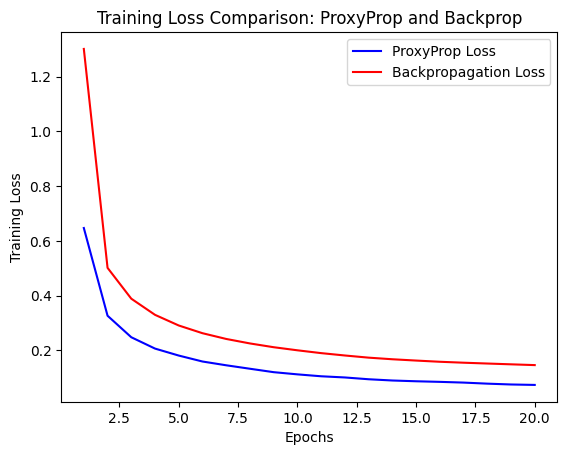

In [12]:
import matplotlib.pyplot as plt
task = Task.get_task(project_name='DNN', task_name='BackPropTask')

proxyProp_loss = task.get_reported_scalars()['Loss']['ProxyProp Loss']
standard_loss = task.get_reported_scalars()['Loss']['Standard Loss']

prop_loss_epochs = proxyProp_loss['x'][1:]
prop_loss_values = proxyProp_loss['y'][1:]

standard_loss_epochs = standard_loss['x']
standard_loss_values = standard_loss['y']

plt.plot(prop_loss_epochs, prop_loss_values, label='ProxyProp Loss', color='blue')
plt.plot(standard_loss_epochs, standard_loss_values, label='Backpropagation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison: ProxyProp and Backprop')

plt.legend()
plt.show()



# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

In [13]:
from memory_profiler import memory_usage

In [14]:
### Your code goes here ###
standard = Network([784, 128, 128, 32, 10], seed = 0)
network = ProxProp([784, 128, 128, 32, 10], seed = 0)

args = ((x_train, y_train), 2, 100, 5.0, (x_test, y_test))
mem_usage_standard = memory_usage((standard.SGD, args, {}))
mem_usage_proxProp = memory_usage((network.SGD, args, {}))

print("Max memory usage for standard backprop", np.max(mem_usage_standard))
print("Max memory usage for proxProp ", np.max(mem_usage_proxProp))

###########################

Epoch: 0, Accuracy: 0.8398, Loss: 1.3018376102290348
Epoch: 1, Accuracy: 0.8893, Loss: 0.501158655332335
Epoch: 0, Accuracy: 0.0793, Loss: 17.314604004135006
Epoch: 1, Accuracy: 0.8991, Loss: 0.6468663048862291
Epoch: 2, Accuracy: 0.9197, Loss: 0.32601134608397253
Max memory usage for standard backprop 1026.4765625
Max memory usage for proxProp  1193.9375
